In [1]:
# Cell 1 — setup
import os, warnings, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets import ISICDataset  # your class

# paths
IMAGE_DIR = r"F:/datasets/ISIC2024/train-image/image"
METADATA_FILE = r"F:/datasets/ISIC2024/train-metadata-balanced.csv"

# load metadata
df = pd.read_csv(METADATA_FILE)
display(df.head(8))
print("Rows:", len(df))
print("Columns:", list(df.columns))

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_9153490,0,IP_7069393,60.0,male,upper extremity,2.60,TBP tile: close-up,3D: XP,21.007710,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.987330
1,ISIC_0157465,0,IP_2331257,55.0,female,upper extremity,3.30,TBP tile: close-up,3D: XP,17.035806,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,94.809008
2,ISIC_6306355,0,IP_4540594,65.0,male,posterior torso,6.05,TBP tile: close-up,3D: XP,21.838689,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,98.336858
3,ISIC_2358370,0,IP_9726832,85.0,male,anterior torso,2.52,TBP tile: close-up,3D: XP,20.954890,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999980
4,ISIC_1565789,0,IP_7293666,65.0,male,anterior torso,3.10,TBP tile: close-up,3D: XP,26.657570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
5,ISIC_1665523,0,IP_3785831,70.0,male,posterior torso,2.77,TBP tile: close-up,3D: white,20.337966,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,98.154205
6,ISIC_7224080,0,IP_8590096,75.0,male,posterior torso,2.56,TBP tile: close-up,3D: white,31.982610,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
7,ISIC_3361287,0,IP_7734648,50.0,male,posterior torso,4.34,TBP tile: close-up,3D: XP,19.631440,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.901890


Rows: 893
Columns: ['isic_id', 'target', 'patient_id', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']


In [2]:
# Cell 2 — missingness + dtypes
display(df.dtypes.to_frame("dtype").T)
missing = (df.isna().mean()*100).sort_values(ascending=False)
display(missing.head(20).rename("missing_%").to_frame())

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
dtype,object,int64,object,float64,object,object,float64,object,object,float64,...,object,object,object,object,object,object,float64,object,float64,float64


,missing_%
iddx_5,100.000000
mel_mitotic_index,94.064950
mel_thick_mm,92.945129
iddx_4,72.900336
iddx_2,55.879059
iddx_3,55.879059
lesion_id,52.519597
sex,3.247480
age_approx,0.559910
anatom_site_general,0.447928


,class,count,frac
0,0,500,0.55991
1,1,393,0.44009


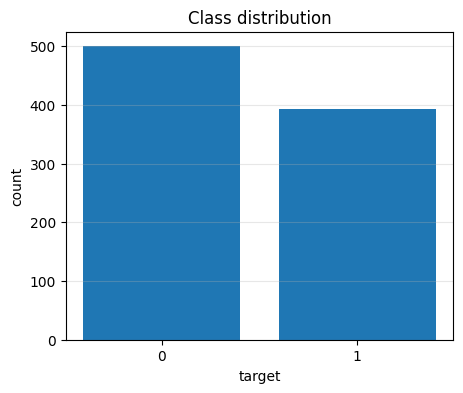

Positive rate (target==1): 44.01 %


In [3]:
# Cell 3 — class balance
assert "target" in df.columns, "Expected 'target' column not found."

vc = df["target"].value_counts().sort_index()
balance = pd.DataFrame({"class": vc.index, "count": vc.values, "frac": vc.values/len(df)})
display(balance)

plt.figure(figsize=(5,4))
plt.bar(vc.index.astype(str), vc.values)
plt.title("Class distribution")
plt.xlabel("target"); plt.ylabel("count"); plt.grid(True, axis="y", alpha=0.3)
plt.show()

print("Positive rate (target==1):", round((df['target']==1).mean()*100, 2), "%")

,count
anatom_site_general,
posterior torso,256
lower extremity,196
anterior torso,193
upper extremity,139
head/neck,105
NA,4


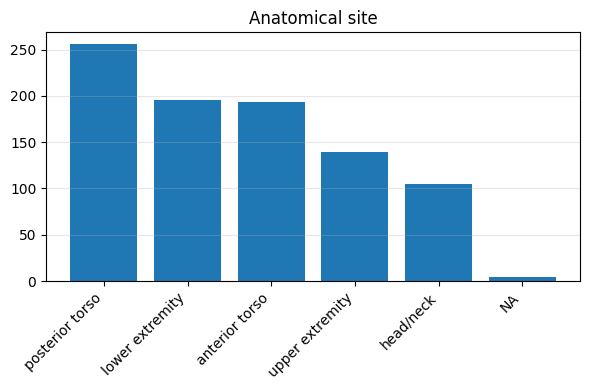

,count
sex,
male,610
female,254
NA,29


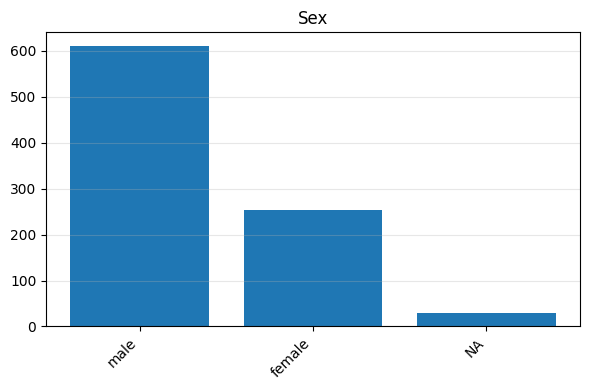

count    888.000000
mean      59.887387
std       12.609777
min       20.000000
25%       50.000000
50%       60.000000
75%       70.000000
max       85.000000
Name: age_approx, dtype: float64

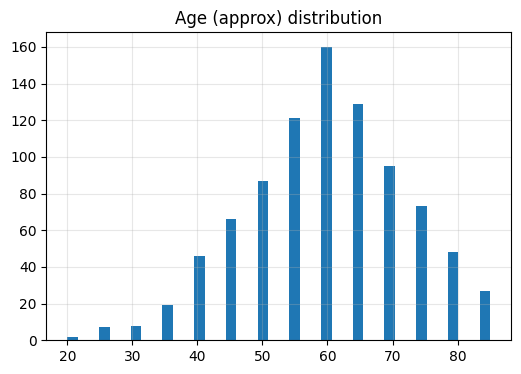

In [4]:
# Cell 4 — optional quick views
def show_bar(col, title):
    if col in df.columns:
        vc = df[col].fillna("NA").value_counts()
        display(vc.to_frame("count"))
        plt.figure(figsize=(6,4))
        plt.bar(vc.index.astype(str), vc.values)
        plt.title(title); plt.xticks(rotation=45, ha="right"); plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()

def show_hist(col, title, bins=40):
    if col in df.columns:
        vals = pd.to_numeric(df[col], errors="coerce").dropna()
        display(vals.describe())
        plt.figure(figsize=(6,4))
        plt.hist(vals, bins=bins)
        plt.title(title); plt.grid(True, alpha=0.3)
        plt.show()

show_bar("anatom_site_general", "Anatomical site")
show_bar("sex", "Sex")
show_hist("age_approx", "Age (approx) distribution")

In [5]:
# Cell 5 — dataset & one batch
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ISICDataset(df, IMAGE_DIR, transform=transform, load_images_to_ram=False)
loader  = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

images, labels, ids = next(iter(loader))
print("Batch images:", images.shape, "| labels:", labels.shape)

Batch images: torch.Size([16, 3, 224, 224]) | labels: torch.Size([16])


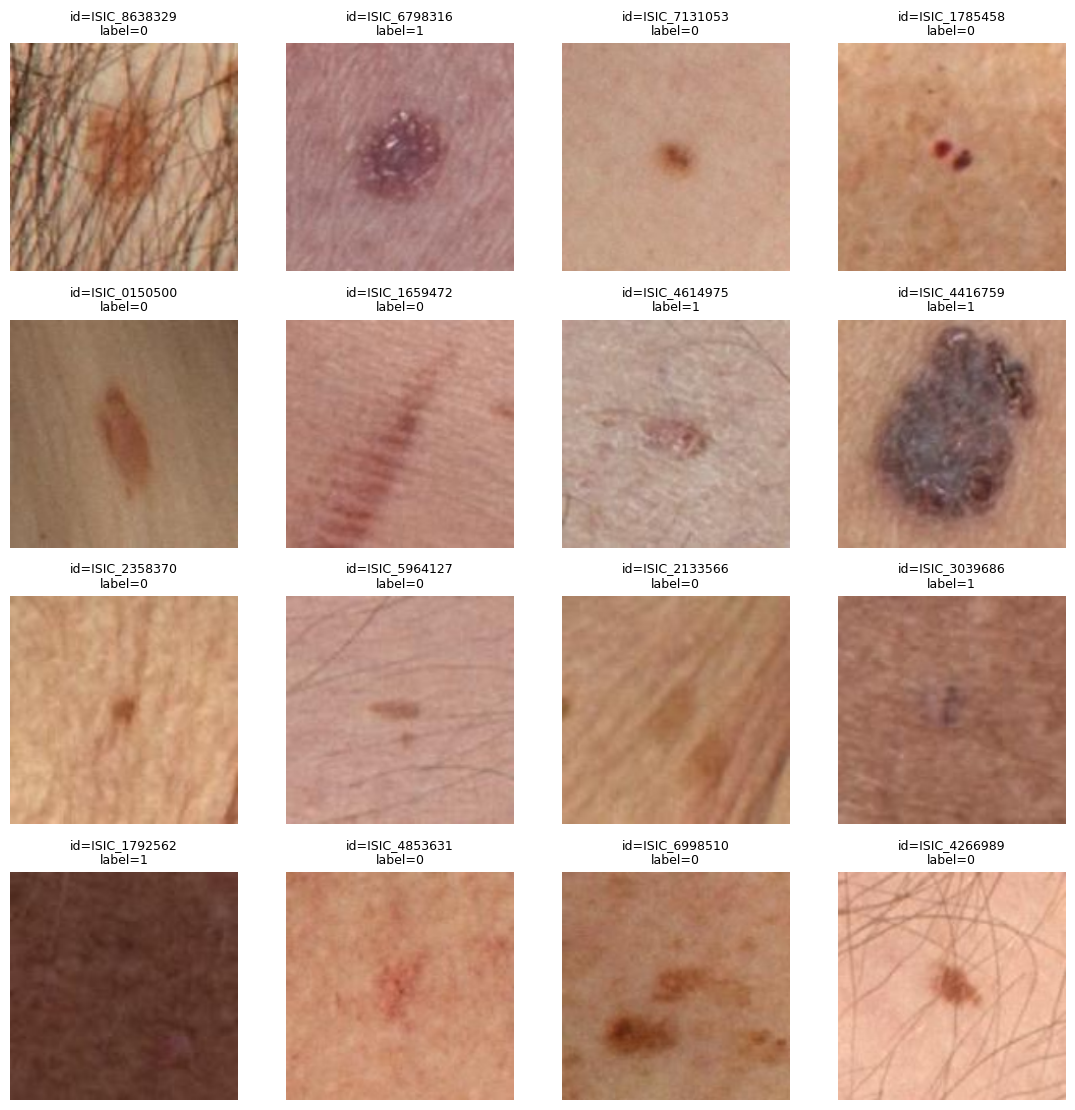

In [6]:
# Cell 6 — sample grid
def show_grid(images, labels, ids, n=16):
    n = min(n, images.size(0))
    cols = int(math.sqrt(n)); rows = int(math.ceil(n/cols))
    plt.figure(figsize=(2.8*cols, 2.8*rows))
    for i in range(n):
        img = images[i].permute(1,2,0).cpu().numpy()
        img = np.clip(img, 0, 1)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"id={ids[i]}\nlabel={int(labels[i])}", fontsize=9)
    plt.tight_layout(); plt.show()

show_grid(images, labels, ids, n=16)